In [33]:
import numpy as np
import os
import torch
from PIL import Image
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import json

In [34]:
print('Pulling NSD webdataset data...')
# Note: using "voxel" naming even though we use vertices here... makes it easier porting over MindEye lingo

train_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/subj01_{3..98}.tar"
val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/subj01_{0..2}.tar"
meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/algonauts_data/wds/metadata_subj01.json"

metadata = json.load(open(meta_url))
num_train = metadata['total'] - 300
num_val = 300
batch_size = 32
num_devices = 1
seed = 42

print('Prepping train and validation dataloaders...')
import math
import random
import webdataset as wds
def my_split_by_node(urls):
    return urls

num_workers = 10

global_batch_size = batch_size * num_devices
num_batches = math.floor(num_train / global_batch_size)
num_worker_batches = math.floor(num_batches / num_workers)

train_data = wds.WebDataset(train_url, resampled=False)\
    .shuffle(500, initial=500, rng=random.Random(seed))\
    .decode("torch")\
    .rename(images="jpg;png", voxels="vert.npy", latent="clip_emb_final.npy")\
    .to_tuple("voxels", "images", "latent")\
    .batched(batch_size, partial=False)\
    .with_epoch(num_worker_batches)

train_dl = torch.utils.data.DataLoader(train_data, num_workers=num_workers,
                        batch_size=None, shuffle=False, persistent_workers=True)

global_batch_size = batch_size
num_workers = 1

num_batches = math.ceil(num_val / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches", num_worker_batches)

val_data = wds.WebDataset(val_url, resampled=False, nodesplitter=my_split_by_node)\
    .decode("torch")\
    .rename(images="jpg;png", voxels="vert.npy", latent="clip_emb_final.npy")\
    .to_tuple("voxels", "images", "latent")\
    .batched(300, partial=False)

val_dl = torch.utils.data.DataLoader(val_data, num_workers=num_workers,
                    batch_size=None, shuffle=False, persistent_workers=True)

Pulling NSD webdataset data...
Prepping train and validation dataloaders...
validation: num_worker_batches 10


In [35]:
# iterate through the training data and create a tensor of all the labels
# this is a bit slow, but it's only done once
print("Creating label tensor")
embeddings = []
images = []
fmri = []

for train_i, (vert, image, clip) in enumerate(tqdm(train_dl)):
    embeddings.append(clip)
    images.append(image)
    fmri.append(vert)

embeddings_train = torch.cat(embeddings)
images_train = torch.cat(images)
fmri_train = torch.cat(fmri) 

# get the mean along the three 
fmri_train = torch.mean(fmri_train, dim=1) 
embeddings_train = embeddings_train.squeeze(1)

Creating label tensor


290it [00:35,  8.09it/s]


In [36]:
images_train.shape

torch.Size([9280, 3, 425, 425])

In [37]:
# iterate through the training data and create a tensor of all the labels
# this is a bit slow, but it's only done once
print("Creating label tensor")
embeddings = []
images = []
fmri = []

for train_i, (vert, image, clip) in enumerate(tqdm(val_dl)):
    embeddings.append(clip)
    images.append(image)
    fmri.append(vert)

embeddings_val = torch.cat(embeddings)
images_val = torch.cat(images)
fmri_val = torch.cat(fmri)

# get the mean along the three 
fmri_val = torch.mean(fmri_val, dim=1) 
embeddings_val = embeddings_val.squeeze(1)

Creating label tensor


1it [00:07,  7.27s/it]


tensor(2810, device='cuda:0')
tensor(1757, device='cuda:0')
l2 distance: tensor(11.5234, device='cuda:0', dtype=torch.float16)
cosine similarity: tensor(0.8174, device='cuda:0', dtype=torch.float16)


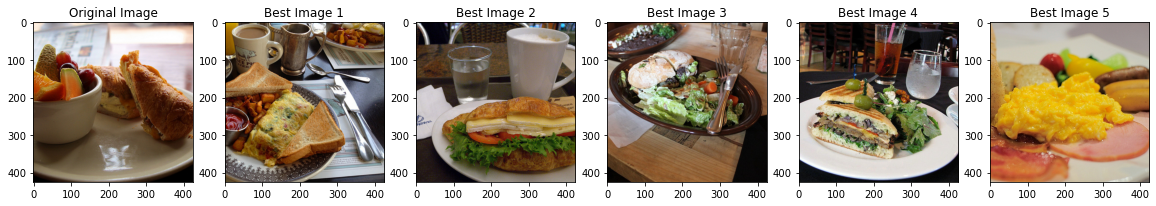

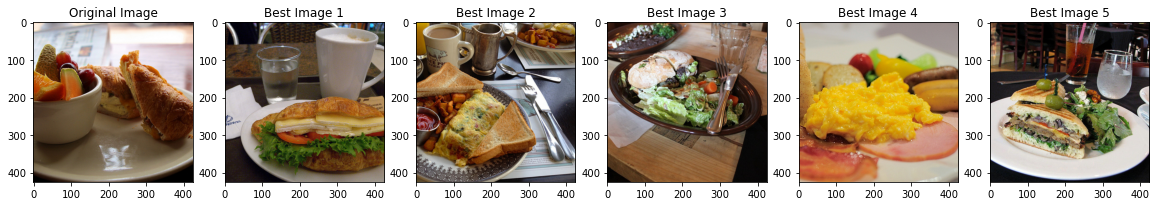

In [67]:
# select the n element of the embedding and find the l2 distance between it and all other embeddings and the cosine similarity

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
embeddings_train = embeddings_train.to(device)

# get the n embedding
n = 100
embedding = embeddings_train[n].to(device)
image = images_train[n].to(device)

# drop the n embedding
embeddings_train_for_distance = torch.cat((embeddings_train[:n], embeddings_train[n + 1:]))
images_train_for_distance = torch.cat((images_train[:n], images_train[n + 1:]))

# calculate the l2 distance between the first embedding and all other embeddings dropped the n embedding
l2_distances = torch.norm(embeddings_train_for_distance - embedding, dim=1)

# calculate the cosine similarity between the first embedding and all other embeddings
cosine_similarities = torch.nn.functional.cosine_similarity(embeddings_train_for_distance, embedding.unsqueeze(0), dim=1)

# sort distances from smallest to largest
l2_distances, l2_distances_idx = torch.sort(l2_distances)
print(l2_distances_idx[0])

# sort cosine similarities from largest to smallest
cosine_similarities, cosine_similarities_idx = torch.sort(cosine_similarities, descending=True)
print(cosine_similarities_idx[0])


# print the l2 distance and cosine similarity of the first embedding with the embedding with the smallest l2 distance
print("l2 distance:", l2_distances[0])
print("cosine similarity:", cosine_similarities[0])

# plot the images corresponding to the first embedding and the embedding with the smallest l2 distance
import matplotlib.pyplot as plt

num_best_images = 5

fig, axs = plt.subplots(1, num_best_images + 1, figsize=(20, 20))

axs[0].imshow(images_train[n].permute(1, 2, 0))
axs[0].set_title("Original Image")

for i in range(num_best_images):
    axs[i + 1].imshow(images_train_for_distance[l2_distances_idx[i]].permute(1, 2, 0))
    axs[i + 1].set_title("Best Image " + str(i + 1))

plt.show()

# plot the images corresponding to the first embedding and the embedding with the largest cosine similarity
fig, axs = plt.subplots(1, num_best_images + 1, figsize=(20, 20))

axs[0].imshow(images_train[n].permute(1, 2, 0))
axs[0].set_title("Original Image")

for i in range(num_best_images):
    axs[i + 1].imshow(images_train_for_distance[cosine_similarities_idx[i].item()].permute(1, 2, 0))
    axs[i + 1].set_title("Best Image " + str(i + 1))

plt.show()



In [68]:
class dummy_model(torch.nn.Module):
    def __init__(self, dict_embedd, dict_image, dict_fmri, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        # embeddings_fmri is a tensor of shape (num_embeddings, 257*768)
        super().__init__()
        self.dict_embedd = dict_embedd.to(device) # shape (dict_num_embeddings, 768)
        self.dict_image = dict_image # shape (dict_num_embeddings, 3, 425, 425)
        self.dict_fmri = dict_fmri # shape (dict_num_embeddings, 39548)
        self.device = device

    def forward(self, input_embeddings, best_num = 1, return_image = False, plot = False, image = None):
        # embeddings is a tensor of shape (batch_size, 768)
        input_embeddings = input_embeddings.to(self.device)
        batch_size = input_embeddings.shape[0]
        # calculate the l2 distance between the input_embeddings and the dict_embeddings shape (batch_size, num_embeddings)
        l2_distances = torch.norm(self.dict_embedd - input_embeddings.unsqueeze(1), dim=2)
        # find the index of the best_num embeddings with the smallest l2 distance shape (batch_size, best_num)
        l2_min_idx = torch.argsort(l2_distances, dim=1)[:, :best_num].to('cpu')
        # get the best_num embeddings with the smallest l2 distance shape (batch_size, best_num, 768)
        l2_min_embeddings = self.dict_embedd.unsqueeze(0).repeat(batch_size, 1, 1).gather(1, l2_min_idx.to(self.device).unsqueeze(2).repeat(1, 1, 768))
        l2_min_fmri = self.dict_fmri.unsqueeze(0).repeat(batch_size, 1, 1).gather(1, l2_min_idx.unsqueeze(2).repeat(1, 1, 39548))
        # calculate the cosine similarity between the input_embeddings and the dict_embeddings shape (batch_size, num_embeddings)
        cosine_similarities = torch.nn.functional.cosine_similarity(self.dict_embedd, input_embeddings.unsqueeze(1), dim=2)
        # find the index of the best_num embeddings with the largest cosine similarity shape (batch_size, best_num)
        cosine_max_idx = torch.argsort(cosine_similarities, dim=1, descending=True)[:, :best_num].to('cpu')
        # get the best_num embeddings with the largest cosine similarity shape (batch_size, best_num, 768)
        cosine_max_embeddings = self.dict_embedd.unsqueeze(0).repeat(batch_size, 1, 1).gather(1, cosine_max_idx.to(self.device).unsqueeze(2).repeat(1, 1, 768))
        cosine_max_fmri = self.dict_fmri.unsqueeze(0).repeat(batch_size, 1, 1).gather(1, cosine_max_idx.unsqueeze(2).repeat(1, 1, 39548))
        
        if return_image == True:
            # get the best_num images with the smallest l2 distance shape (batch_size, best_num, 3, 448, 448)
            l2_min_images = torch.zeros(batch_size, best_num, 3, 425, 425)
            for i in range(batch_size):
                for j in range(best_num):
                    l2_min_images[i, j] = self.dict_image[l2_min_idx[i, j]]
            # get the best_num images with the largest cosine similarity shape (batch_size, best_num, 3, 448, 448)
            cosine_max_images = torch.zeros(batch_size, best_num, 3, 425, 425)
            for i in range(batch_size):
                for j in range(best_num):
                    cosine_max_images[i, j] = self.dict_image[cosine_max_idx[i, j]]

            
        if plot == True:
            num_best_images = 5
            fig, axs = plt.subplots(input_embeddings.shape[0], num_best_images + 1, figsize=(20, 20))
            for i in range(input_embeddings.shape[0]):
                axs[i, 0].imshow(self.dict_image[l2_min_idx[i, 0]].permute(1, 2, 0))
                axs[i, 0].set_title("Original Image")
                for j in range(num_best_images):
                    axs[i, j + 1].imshow(l2_min_images[i, j].permute(1, 2, 0))
                    axs[i, j + 1].set_title("Best Image " + str(j + 1))
            plt.show()

            fig, axs = plt.subplots(input_embeddings.shape[0], num_best_images + 1, figsize=(20, 20))
            for i in range(input_embeddings.shape[0]):
                axs[i, 0].imshow(self.dict_image[cosine_max_idx[i, 0]].permute(1, 2, 0))
                axs[i, 0].set_title("Original Image")
                for j in range(num_best_images):
                    axs[i, j + 1].imshow(cosine_max_images[i, j].permute(1, 2, 0))
                    axs[i, j + 1].set_title("Best Image " + str(j + 1))
            plt.show()

        return (l2_min_embeddings, l2_min_images, l2_min_fmri, cosine_max_embeddings, cosine_max_images, cosine_max_fmri) if return_image else (l2_min_embeddings, l2_min_fmri, cosine_max_embeddings, cosine_max_fmri)

# Test the model
model = dummy_model(embeddings_train, images_train, fmri_train)

l2_min_embeddings, l2_min_images, l2_min_fmri, cosine_max_embeddings, cosine_max_images, cosine_max_fmri = model(embeddings_val[10:20], best_num = 5, return_image = True, plot = False)

In [69]:
print(model.dict_image.shape)

torch.Size([9280, 3, 425, 425])


In [70]:
cosine_max_images[0,1]

tensor([[[0.8000, 0.8235, 0.8235,  ..., 0.7451, 0.7686, 0.7765],
         [0.8235, 0.8118, 0.8118,  ..., 0.7412, 0.7569, 0.7529],
         [0.8275, 0.8275, 0.8118,  ..., 0.7569, 0.7569, 0.7529],
         ...,
         [0.5176, 0.4118, 0.2784,  ..., 0.4784, 0.3686, 0.4235],
         [0.4588, 0.4471, 0.3451,  ..., 0.2941, 0.3294, 0.3255],
         [0.3961, 0.3216, 0.3020,  ..., 0.1961, 0.1333, 0.0980]],

        [[0.8549, 0.8706, 0.8627,  ..., 0.8392, 0.8431, 0.8275],
         [0.8588, 0.8588, 0.8667,  ..., 0.8235, 0.8392, 0.8157],
         [0.8510, 0.8667, 0.8667,  ..., 0.8314, 0.8353, 0.8314],
         ...,
         [0.4667, 0.3647, 0.2314,  ..., 0.4275, 0.3216, 0.3804],
         [0.4039, 0.4039, 0.3176,  ..., 0.2314, 0.2627, 0.2784],
         [0.3255, 0.2627, 0.2745,  ..., 0.1216, 0.0863, 0.0824]],

        [[0.9059, 0.9176, 0.9020,  ..., 0.8471, 0.8667, 0.8941],
         [0.9176, 0.9059, 0.9020,  ..., 0.8431, 0.8588, 0.8667],
         [0.9137, 0.9059, 0.9020,  ..., 0.8588, 0.8627, 0.

# L2 distance

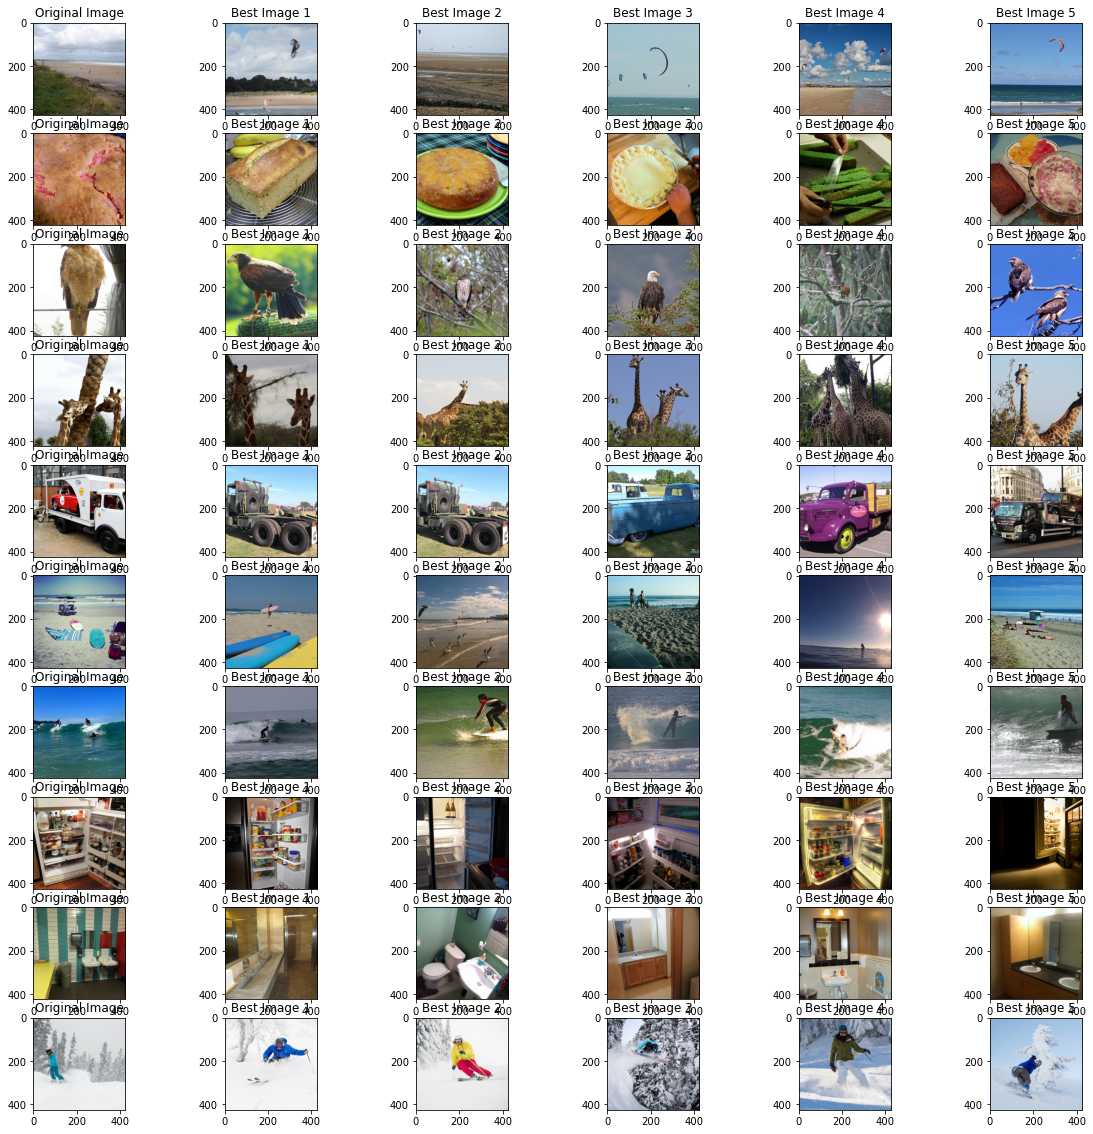

In [71]:
# plet the l2_min_images and the original images
fig, axs = plt.subplots(10, 6, figsize=(20, 20))
for i in range(10):
    axs[i, 0].imshow(images_val[10+i].permute(1, 2, 0))
    axs[i, 0].set_title("Original Image")
    for j in range(5):
        axs[i, j + 1].imshow(l2_min_images[i, j].permute(1, 2, 0))
        axs[i, j + 1].set_title("Best Image " + str(j + 1))

# Cosine similarity

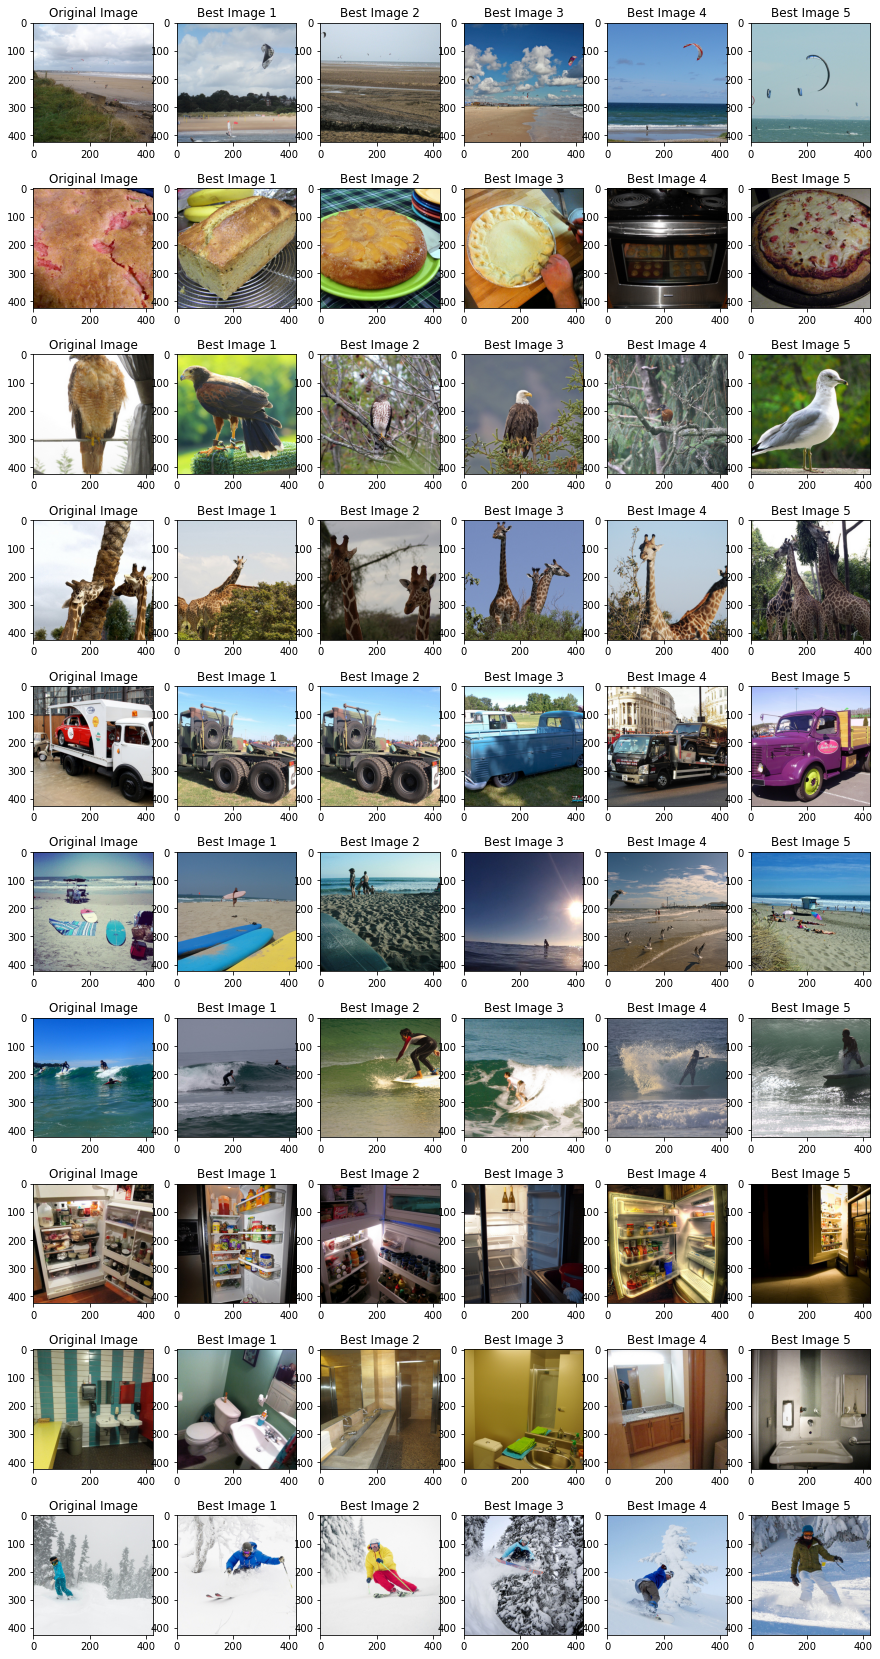

In [72]:
# plet the l2_min_images and the original images
fig, axs = plt.subplots(10, 6, figsize=(15, 30))
for i in range(10):
    axs[i, 0].imshow(images_val[10+i].permute(1, 2, 0))
    axs[i, 0].set_title("Original Image")
    for j in range(5):
        axs[i, j + 1].imshow(cosine_max_images[i, j].permute(1, 2, 0))
        axs[i, j + 1].set_title("Best Image " + str(j + 1))

In [73]:
# Iterate over the val set and get the predictions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def get_predictions(model, val_dl):
    model.eval()
    preds_cos = []
    preds_l2 = []
    with torch.no_grad():
        for (vert, image, clip_vitl_final) in tqdm(val_dl):
            vert = torch.mean(vert, dim=1) 
            clip_vitl_final = clip_vitl_final.squeeze(1)
            l2_min_embeddings, l2_min_images, l2_min_fmri, cosine_max_embeddings, cosine_max_images, cosine_max_fmri = model(clip_vitl_final, best_num = 1, return_image = True, plot = False)
            preds_l2.append(l2_min_fmri)
            preds_cos.append(cosine_max_fmri)
        preds_cos = torch.cat(preds_cos, dim=0)
        preds_l2 = torch.cat(preds_l2, dim=0)
    return preds_cos, preds_l2
preds_cos, preds_l2 = get_predictions(model, val_dl)

1it [00:51, 51.26s/it]


In [74]:
preds_cos.shape, preds_l2.shape

(torch.Size([300, 1, 39548]), torch.Size([300, 1, 39548]))

In [75]:
preds_cos = preds_cos[:,0,:]
preds_l2 = preds_l2[:,0,:]

In [76]:
# 20544 above is the number of fmri on the right hemisphere
y_val_right_pred = preds_cos[:, 20544:]
y_val_left_pred = preds_cos[:, :20544]

rh_fmri_val = fmri_val[:, 20544:]
lh_fmri_val = fmri_val[:, :20544]

from tqdm import tqdm
from scipy.stats import pearsonr as corr
# Empty correlation array of shape: (LH vertices)
lh_correlationcos = np.zeros(y_val_left_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(y_val_left_pred.shape[1])):
    lh_correlationcos[v] = corr(y_val_left_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlationcos = np.zeros(y_val_right_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(y_val_right_pred.shape[1])):
    rh_correlationcos[v] = corr(y_val_right_pred[:,v], rh_fmri_val[:,v])[0]

# 20544 above is the number of fmri on the right hemisphere
y_val_right_pred = preds_l2[:, 20544:]
y_val_left_pred = preds_l2[:, :20544]

rh_fmri_val = fmri_val[:, 20544:]
lh_fmri_val = fmri_val[:, :20544]

from tqdm import tqdm
from scipy.stats import pearsonr as corr
# Empty correlation array of shape: (LH vertices)
lh_correlationl2 = np.zeros(y_val_left_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(y_val_left_pred.shape[1])):
    lh_correlationl2[v] = corr(y_val_left_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlationl2 = np.zeros(y_val_right_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(y_val_right_pred.shape[1])):
    rh_correlationl2[v] = corr(y_val_right_pred[:,v], rh_fmri_val[:,v])[0]

print("Corr cos: ", "\nRight:", rh_correlationcos.mean(), "\nLeft:", lh_correlationcos.mean())
print("Corr l2: ", "\nRight:", rh_correlationl2.mean(), "\nLeft:", lh_correlationl2.mean())

100%|██████████| 19004/19004 [00:01<00:00, 10389.49it/s]

Corr cos:  
Right: 0.16949740031083657 
Left: 0.15869317995640342
Corr l2:  
Right: 0.17184310716596463 
Left: 0.16572455347782217
